In [2]:
import yastn
import yastn.tn.mps as mps
import matplotlib.pyplot as plt
import numpy as np
from operators import HXXZ, sumLn2, Ln, momentum_total, momentum_n, measure_energy_per_site

In [3]:
ops = yastn.operators.Spin12(sym='U1')  # "U1" enforces sum(Sz) conservation
g = 1 / 5
m = g / 8

L0 = 0.0
v = Q = 1.0

First, test energy per site in the ground state.

In [20]:
engs, out = {}, {}
t = 0
for N, a in [(160, 1), (640, 0.25)]:
    print("N =", N, "a =", a)
    e0 = a * g * g / 2
    H0 = HXXZ(N, a, m, ops=ops)
    H1 = e0 * sumLn2(N, t, L0, v, Q, ops=ops)
    D = 64
    charge = 0 # this is a total Sz-spin for U1 symmetry
    psi = mps.random_mps(H0, D_total=D, n=charge)
    # 2 sweeps of 2-site dmrg
    mps.dmrg_(psi, [H0, H1], max_sweeps=2, energy_tol=1e-10, method='2site', opts_svd={"D_total": D})
    # followed by 1-site sweeeps
    out[N] = mps.dmrg_(psi, [H0, H1], max_sweeps=100, energy_tol=1e-12, method='1site')
    print(out[N])
    engs[N] = measure_energy_per_site(psi, a, e0, m, t, L0, v, Q, ops)



N = 160 a = 1
DMRG_out(sweeps=13, energy=-47.96074353543413, denergy=6.963318810448982e-13, max_dSchmidt=None, max_discarded_weight=None)
N = 640 a = 0.25
DMRG_out(sweeps=46, energy=-805.0754244328382, denergy=7.958078640513122e-13, max_dSchmidt=None, max_discarded_weight=None)


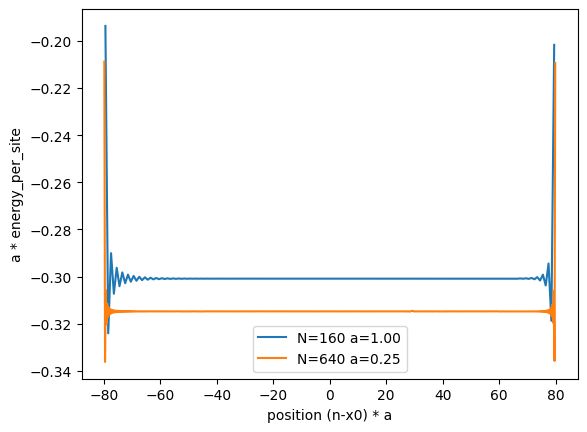

In [22]:
for N, a in [(160, 1), (640, 0.25)]:
    assert abs((sum(engs[N]) - out[N].energy) / out[N].energy)  < 1e-12  # test energy calculation
    pos = (np.arange(N) - (N - 1)/2) * a
    plt.plot(pos, engs[N] * a, label=f"{N=} {a=:0.2f}")
    plt.xlabel("position (n-x0) * a")
    plt.ylabel("a * energy_per_site")
plt.legend()


Now take N=160, and focus on dynamics

In [5]:
N, a = 160, 1
e0 = a * g * g / 2
t = 0
H0 = HXXZ(N, a, m, ops=ops)
H1 = e0 * sumLn2(N, t, L0, v, Q, ops=ops)

D = 64
charge = 0 # this is a total Sz-spin for U1 symmetry
psi_gs = mps.random_mps(H0, D_total=D, n=charge)
# 2 sweeps of 2-site dmrg
mps.dmrg_(psi_gs, [H0, H1], max_sweeps=2, energy_tol=1e-10, method='2site', opts_svd={"D_total": D})
# followed by 1-site sweeeps
info = mps.dmrg_(psi_gs, [H0, H1], max_sweeps=100, energy_tol=1e-12, method='1site')
print(info)
engs_gs = measure_energy_per_site(psi_gs, a, e0, m, t, L0, v, Q, ops)



DMRG_out(sweeps=14, energy=-47.96073533202091, denergy=5.826450433232822e-13, max_dSchmidt=None, max_discarded_weight=None)


In [10]:
mops = [momentum_n(n, N, ops) for n in range(1, N-1)]

In [24]:
engs_time = []
mops_time = []
ents_time = []
times=[0, 4, 8, 12, 16]
psi = psi_gs.copy()
Ht = lambda t: [H0, e0 * sumLn2(N, t, L0, v, Q, ops=ops)]
for step in mps.tdvp_(psi, Ht, times, dt=0.125, method='1site'):
    print(step)
    engs_time.append(measure_energy_per_site(psi, a, e0, m, step.tf, L0, v, Q, ops))
    mops_time.append([mps.vdot(psi, op, psi) for op in mops])
    ents_time.append(psi.get_entropy())


TDVP_out(ti=0, tf=4.0, time_independent=False, dt=0.125, steps=32)
TDVP_out(ti=4, tf=8.0, time_independent=False, dt=0.125, steps=32)
TDVP_out(ti=8, tf=12.0, time_independent=False, dt=0.125, steps=32)
TDVP_out(ti=12, tf=16.0, time_independent=False, dt=0.125, steps=32)


Text(0.5, 1.0, 'g=0.2 m=0.025 a=1 N=160')

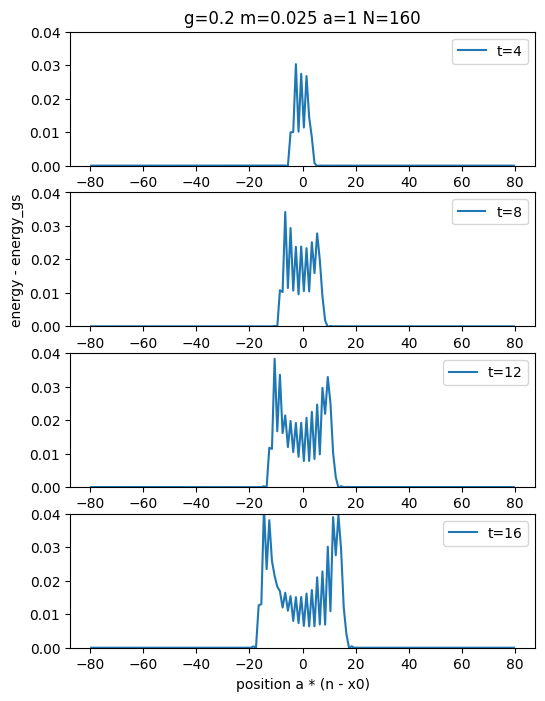

In [40]:
pos = (np.arange(N) - (N - 1)/2) * a
fig, ax = plt.subplots(len(engs_time), 1)
fig.set_size_inches(6, 2 * len(engs_time))
for ii, ee in enumerate(engs_time):
    ax[ii].plot(pos, ee - engs_gs, label=f"t={times[ii + 1]}")
    ax[ii].legend()
    ax[ii].set_ylim([0, 0.04])
ax[1].set_ylabel("energy - energy_gs")
ax[-1].set_xlabel("position a * (n - x0)")
ax[0].set_title(f"{g=} {m=} {a=} {N=}")

Text(0.5, 1.0, 'g=0.2 m=0.025 a=1 N=160')

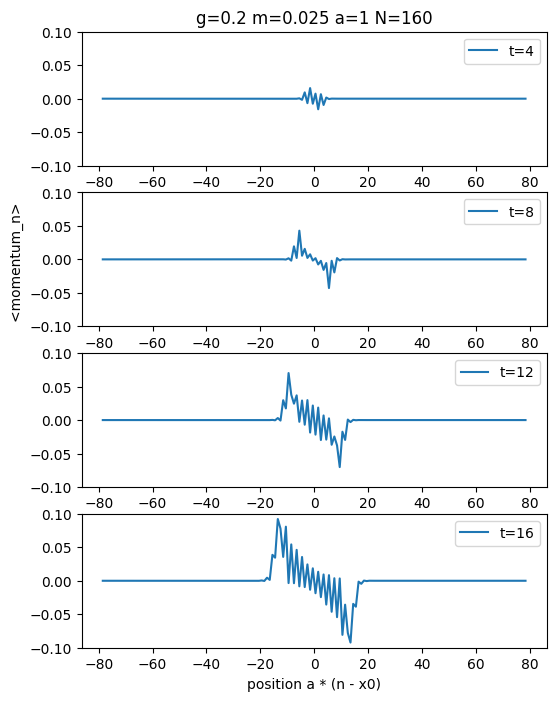

In [39]:
pos = (np.arange(1, N-1) - (N - 1)/2) * a
fig, ax = plt.subplots(len(engs_time), 1)
fig.set_size_inches(6, 2 * len(engs_time))
for ii, ee in enumerate(mops_time):
    ax[ii].plot(pos, ee, label=f"t={times[ii + 1]}")
    ax[ii].legend()
    ax[ii].set_ylim([-0.1, 0.1])
ax[1].set_ylabel("<momentum_n> ")
ax[-1].set_xlabel("position a * (n - x0)")
ax[0].set_title(f"{g=} {m=} {a=} {N=}")

Text(0.5, 1.0, 'g=0.2 m=0.025 a=1 N=160')

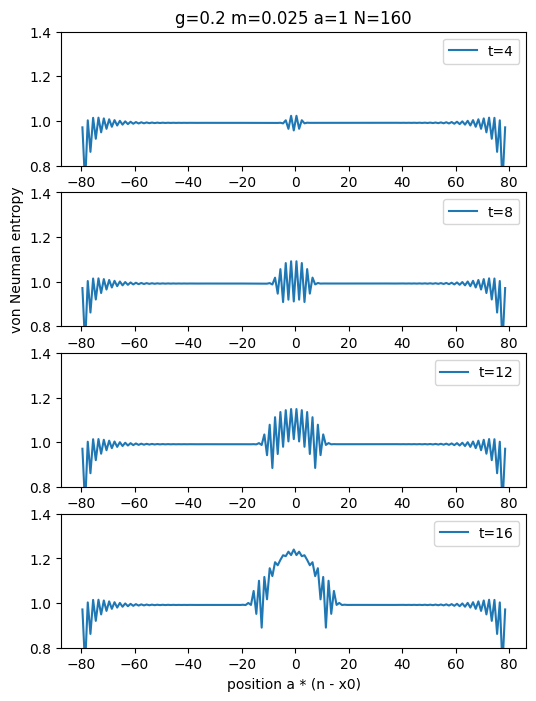

In [44]:
pos = (np.arange(N-1) - (N - 1)/2) * a
fig, ax = plt.subplots(len(engs_time), 1)
fig.set_size_inches(6, 2 * len(engs_time))
for ii, ee in enumerate(ents_time):
    ax[ii].plot(pos, ee[1:-1], label=f"t={times[ii + 1]}")
    ax[ii].legend()
    ax[ii].set_ylim([0.8, 1.4])
ax[1].set_ylabel("von Neuman entropy")
ax[-1].set_xlabel("position a * (n - x0)")
ax[0].set_title(f"{g=} {m=} {a=} {N=}")

In [46]:
engs_total = [sum(engs_gs)] + [sum(ee) for ee in engs_time]

Text(0, 0.5, 'total energy')

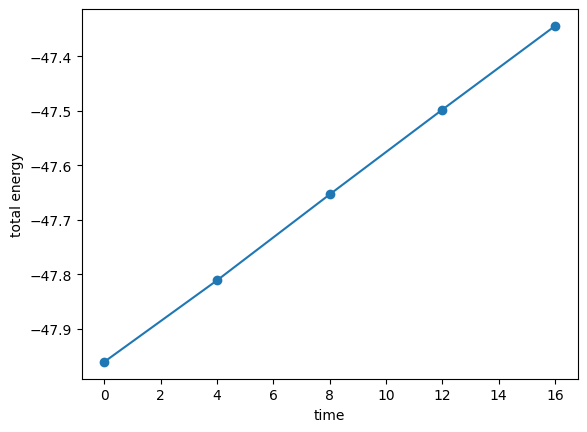

In [48]:
plt.plot(times, engs_total, '-o')
plt.xlabel("time")
plt.ylabel("total energy")